# Баесовские Модели: Регуляризация

In [1]:
%matplotlib inline
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots
from IPython.core.pylabtools import figsize
plt.style.use(['science', 'notebook', 'grid'])

Представим, что вы являетесь аспирантом математической кафедры.  

Внезапно к вам обращается командир артиллерийского дивизиона военного училища с просьбой помочь в решении сложной задачи. Он предоставляет вам обширную систему линейных уравнений $Aw = V$, используемую для расчета углов артиллерийского огня.  

Основная сложность заключается в том, что в уравнениях учтены различные факторы с определенной погрешностью, обозначенной как $x\pm\epsilon$. Это приводит к тому, что определитель соответствующей матрицы стремится к нулю, что, в свою очередь, означает, что в случае наличия решения, их может быть бесконечно много.  

К тому же, размер матрицы настолько велик, что невозможно точно вычислить зависимости. В такой ситуации товарищ полковник просит вас найти метод вычисления хотя бы одного приближенного решения.


In [2]:
matrix = np.array([[1,6],
                   [3,18]])
V = np.array([[12],
              [36]])
#Хоть матрица и не обратима решений будет бесконечно много, нам нужно любое из решений
print("Определитель марицы: ", np.linalg.det(matrix))

Определитель марицы:  0.0


Одним из методов решения может быть применение спектрального разложения матрицы с последующей заменой всех её нулевых собственных значений на очень малые положительные числа, чтобы избежать проблемы вырожденности.

In [3]:
eig_val, eig_vec = np.linalg.eig(matrix)

print("Собственные значения:", eig_val)

# Замена первого собственного значения на малое положительное число
eig_val[0] = 1.e-8

# Восстановление матрицы с измененным спектром
matrix_restore = eig_vec @ np.diag(eig_val) @ np.linalg.inv(eig_vec)

w_restore = np.linalg.solve(matrix_restore, V)


print("Восстановленная матрица: \n", matrix_restore)
print("Определитель восстановленной матрицы: ", np.linalg.det(matrix_restore))

print("\n Решение: \n", w_restore)
print("\n Проверка: A@w: \n", matrix@w_restore)

Собственные значения: [ 0. 19.]
Восстановленная матрица: 
 [[ 1.00000001  6.        ]
 [ 3.         18.        ]]
Определитель восстановленной матрицы:  1.9000000496252978e-07

 Решение: 
 [[0.63157898]
 [1.89473684]]

 Проверка: A@w: 
 [[12.]
 [36.]]


Но поскольку нам не очень хочется искать для огромной матрицы сингулярное разложение есть способ по проще избавится от нулевого определителя: просто добавить к нашей матрице единичную умноженную на очень маленькое число $\lambda \rightarrow 0$.  


$A_{det\neq 0} \approx A_{det = 0}+ \lambda E$  

Такой подход исправления матрицы называется регуляризацией

In [4]:
lam = 1.e-08
matrix_fix = matrix+lam*np.eye(2)

w_fix = np.linalg.solve(matrix_fix, V)
print("Исправленная матрица: \n", matrix_fix)
print("Определитель исправленной матрицы: ", np.linalg.det(matrix_fix))

print("\n Решение: \n", w_fix)
print("\n Проверка: A@w: \n", matrix@w_fix)

Исправленная матрица: 
 [[ 1.00000001  6.        ]
 [ 3.         18.00000001]]
Определитель исправленной матрицы:  1.8999999973345894e-07

 Решение: 
 [[0.63157899]
 [1.89473683]]

 Проверка: A@w: 
 [[11.99999999]
 [35.99999998]]


Если решений у системы бесконечно много тогда мы получаем хорошее приблизительные решение, а если изначальная система не имела решений (вектор $V$ не лежит в линейном пространстве который построен на векторах матрицы $A$) наше тогда наше приблизительное решение будет стремиться к бесконечности

In [5]:
V_bad = np.array([[1],
              [1]])

w_bad = np.linalg.solve(matrix_fix, V_bad)

print("Решение: \n", w_bad)

print("\n Проверка: A@w: \n", matrix@w_bad,"\n Вместо: \n", V_bad)

Решение: 
 [[ 63157894.87807459]
 [-10526315.75160892]]

 Проверка: A@w: 
 [[0.36842106]
 [1.10526317]] 
 Вместо: 
 [[1]
 [1]]


В машинном обучении подобные проблемы также встречаются, особенно когда признаки в наборе данных сильно скоррелированы. В таких случаях матрица $X^TX$ может иметь нулевой или очень малый определитель.  
Это приводит к нестабильности решения: модель стремится идеально соответствовать обучающим данным которые не лежат в ее линейном пространстве, что может привести к непомерно большим весам как в примере выше.
Кроме того, разряженная модель очень плохо обучается за счет градиентного спуска

Определитель истинной прямой:  3697.673298642999
Определитель модели:  1.4397377621055408e-15


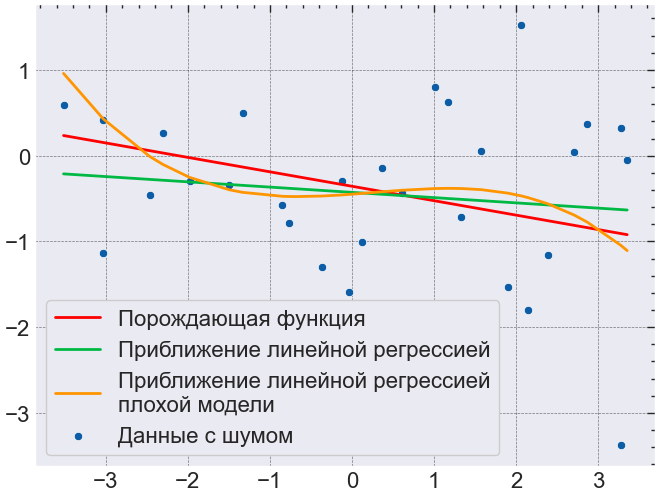

In [6]:
np.random.seed(23)

LinSp = np.linspace(-4,4,100)

n = 30
X = np.random.choice(LinSp, size = (n,1))
X_true = np.hstack([X, np.ones((n, 1))])
X_model = np.hstack([X, 2*X+0.001*X**2+2, 7*X+3, 6*X+0.001*X**3, np.ones((n, 1))])

w_true = np.random.randn(2,1)
epsilon = np.random.randn(n,1)

y = X_true@w_true + epsilon

w_mse_model = np.linalg.inv(X_model.T@X_model)@X_model.T@y
w_mse_true = np.linalg.inv(X_true.T@X_true)@X_true.T@y

print("Определитель истинной прямой: ", np.linalg.det(X_true.T@X_true) )
print("Определитель модели: ", np.linalg.det(X_model.T@X_model) )

sns.lineplot(x=X[:, 0], y=(X_true @ w_true)[:, 0], color='red', linewidth=2, label='Порождающая функция')
sns.lineplot(x=X[:, 0], y=(X_true @ w_mse_true)[:, 0], color='C1', linewidth=2, label='Приближение линейной регрессией')
sns.lineplot(x=X[:, 0], y=(X_model @ w_mse_model)[:, 0], color='C2', linewidth=2, label='Приближение линейной регрессией\nплохой модели')

sns.scatterplot(x=X[:, 0], y=y[:, 0], label='Данные с шумом')

plt.show()

In [7]:
print("Веса истинной прямой: \n", w_true)
print("Веса модели :\n", w_mse_model)

Веса истинной прямой: 
 [[-0.16834479]
 [-0.35671283]]
Веса модели :
 [[795.86235303]
 [ 24.73177118]
 [-93.9664269 ]
 [-31.24810469]
 [231.98642492]]


Обратите внимание, что возможность нахождения обратной матрицы в данном случае обусловлена использованием функции np.linalg.det, которая вычисляет определитель с использованием численных методов, основанных на поиске собственных значений через SVD (сингулярное разложение).  
Если бы мы рассчитывали определитель точно, то он оказался бы равным нулю, что делает матрицу вырожденной и, следовательно, необратимой.

Нормализация модели также не сильно уменьшает значения весов, а иногда даже увеличивает, так как признаки остаются скорелированы

In [8]:
mean_y = np.mean(y)
std_y = np.std(y)
y_normalize = (y - mean_y) / std_y

means_X = np.mean(X_model, axis=0)[:4, None]
stds_X = np.std(X_model, axis=0)[:4, None]
X_normalize = (X_model[:,:4] - means_X.T) / stds_X.T

std_matrix = np.diag(stds_X.ravel())

w_normalize = stds_X[0,0]*w_true[0]/std_y

w_mse_model_normalize = std_matrix @ w_mse_model[:4] / std_y
w_mse_true_normalize = stds_X[0,0]*w_mse_true[0]/std_y

print("Веса истинной прямой: \n", w_normalize)
print("Веса модели :\n", w_mse_model_normalize)

Веса истинной прямой: 
 [-0.34726929]
Веса модели :
 [[ 1641.74106321]
 [  102.04567048]
 [-1356.86753764]
 [ -387.2670201 ]]


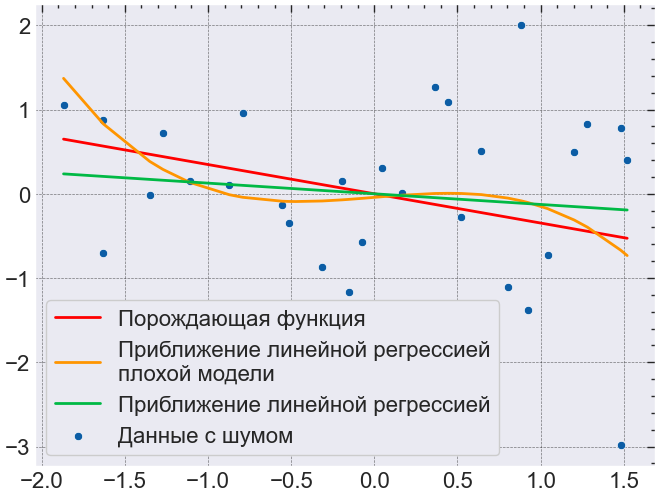

In [9]:
sns.lineplot(x=X_normalize[:, 0], y=(X_normalize[:,0] * w_normalize[0]), color='red', linewidth=2, label='Порождающая функция')
sns.lineplot(x=X_normalize[:, 0], y=(X_normalize @ w_mse_model_normalize)[:, 0], color='C2', linewidth=2, label='Приближение линейной регрессией\nплохой модели')
sns.lineplot(x=X_normalize[:, 0], y=(X_normalize[:,0] * w_mse_true_normalize[0]), color='C1', linewidth=2, label='Приближение линейной регрессией')

sns.scatterplot(x=X_normalize[:, 0], y=y_normalize[:, 0], label='Данные с шумом')

plt.show()

Одним из рациональных способов решения этой проблемы является введение ограничений на величину весов $w$, чтобы предотвратить поиск моделью решений за пределами её линейного пространства, что в свою очередь приводит к избежанию чрезмерно больших значений весов.

Как пример введения ограничений, можно рассмотреть штраф к нашей функции ошибки в виде $\lambda \sum_i w_i^2 = \lambda w^Tw$, тогда нашу функцию ошибки можно переписать в виде:

$(Xw-y)^T(Xw-y)+\lambda w^Tw$  

Взяв градиент получаем:

$\nabla [\ (Xw-y)^T(Xw-y)+\lambda w^Tw \ ] = 2X^TXw -2X^Ty +2\lambda w =0 \ \Rightarrow \ (X^TX+\lambda E)w = X^Ty \ \Rightarrow \ w = (X^TX+\lambda E)^{-1}X^Ty$

Таким образом, ограничение весов приводит к введению регуляризации для матрицы с малым определителем $X^TX$, которая трансформируется в регуляризованную матрицу $(X^TX + \lambda E)$

Веса модели: 
 [[-0.00494516]
 [ 0.24876416]
 [-0.00494516]
 [-0.36538983]]


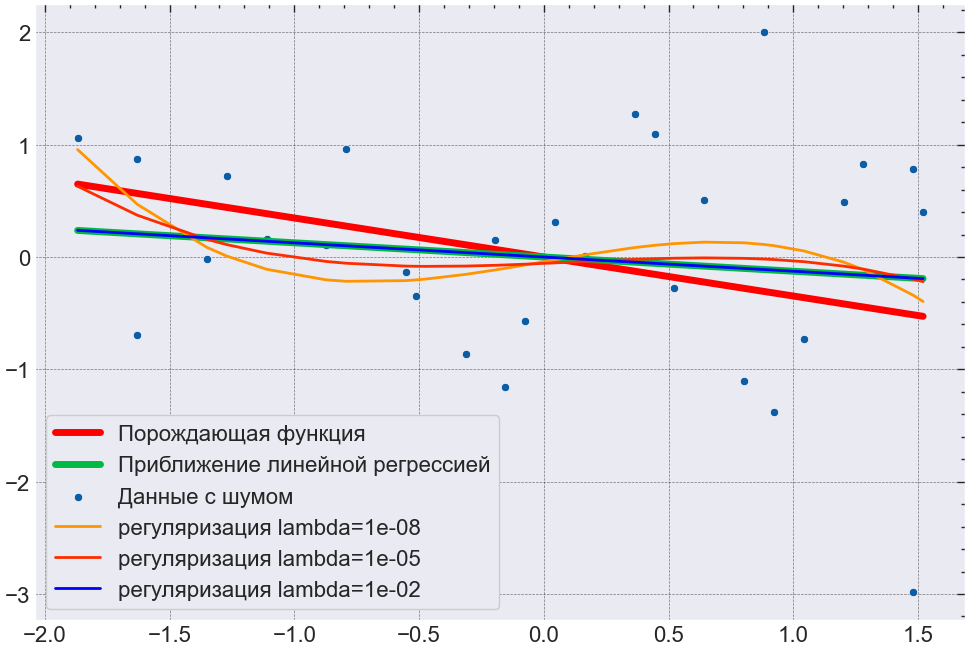

In [10]:
lambdas = [1.e-8, 1.e-5, 1.e-2]
E = np.eye(4)
colors = ['C2', 'C3', 'b']

plt.figure(figsize = (12,8))
sns.lineplot(x=X_normalize[:, 0], y=(X_normalize[:,0] * w_normalize[0]), color='red', linewidth=5, label='Порождающая функция')
sns.lineplot(x=X_normalize[:, 0], y=(X_normalize[:,0] * w_mse_true_normalize[0]), color='C1', linewidth=5, label='Приближение линейной регрессией')

sns.scatterplot(x=X_normalize[:, 0], y=y_normalize[:, 0], label='Данные с шумом')

# Цикл для регуляризации
for i, l in enumerate(lambdas):
    inv_reg = np.linalg.inv(X_normalize.T @ X_normalize + l * E)
    w_reg_model = inv_reg @ X_normalize.T @ y_normalize
    sns.lineplot(x=X_normalize[:, 0], y=(X_normalize @ w_reg_model)[:, 0], color=colors[i], linewidth=2, label='регуляризация lambda=%1.e' % l)

print("Веса модели: \n", w_reg_model)

Таким образом модель ищет признаки в своем линейном пространстве

## Регуляризация с точки зрения байесовского подхода

С точки зрения байесовского подхода задача регуляризации возникает сама по себе, когда мы вводим априорное распределение на веса $  P(w)  $:

$  P(w|D) = \frac{P(D|w)P(w)}{P(D)} \propto P(D|w)P(w)  $

Например, если мы предполагаем, что наши данные пришли к нам из нормального распределения $  y_i \sim \mathcal{N}(x_i^T w, \sigma_y)  $, тогда в качестве сопряженного априорного распределения на веса логично было бы взять также нормальное, а так как мы хотим, чтобы наша регрессия не переобучалась, центр должен быть в нуле $  w \sim \mathcal{N}(0,\sigma_w E)  $ тогда:

$  \ln P(w|D) = \ln P(D|w) + \ln P(w) - \ln P(D) = -\sum\limits_i \frac{(x_i^T w - y_i)^2}{2\sigma_y^2} - \sum_j \frac{w_j^2}{2\sigma_w^2} = -\frac{\|Xw - y\|^2}{2\sigma_y^2} - \frac{w^Tw}{2\sigma_w^2} + Const  $

При нахождении максимума нашей вероятности $  P(w|D)  $, получаем ту же оптимизацию, только в данном случае $  \lambda = \frac{\sigma_y^2}{\sigma_w^2}  $

In [13]:
import pymc as pm

with pm.Model() as lin_model_non_reg:
    w_bad_model_pm = pm.Flat("w", shape = (4,1))
    y_obs = pm.Normal("y_obs", X_normalize@w_bad_model_pm, sigma = 1, observed=y_normalize)

lin_model_non_reg

In [14]:
with lin_model_non_reg:
    lin_model_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2335 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 177 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


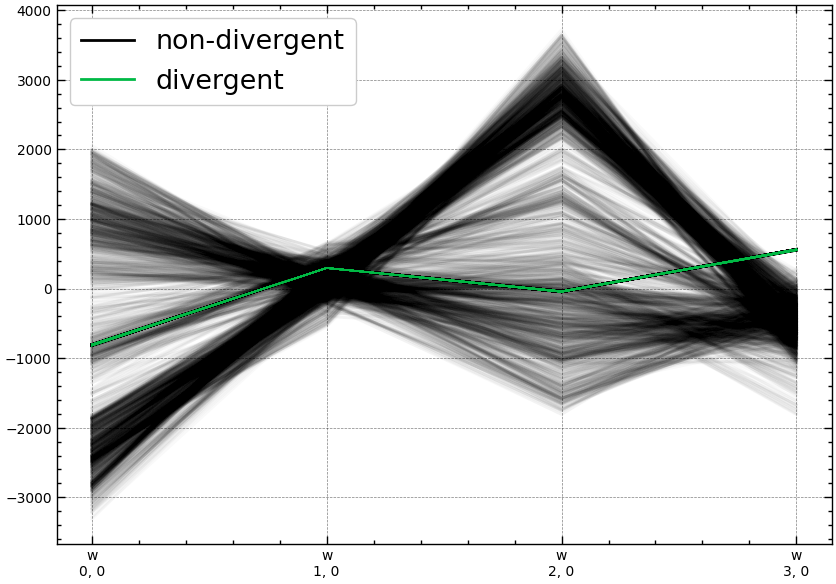

In [15]:
import arviz as az
az.plot_parallel(lin_model_trace, figsize=(10, 7))
plt.show()

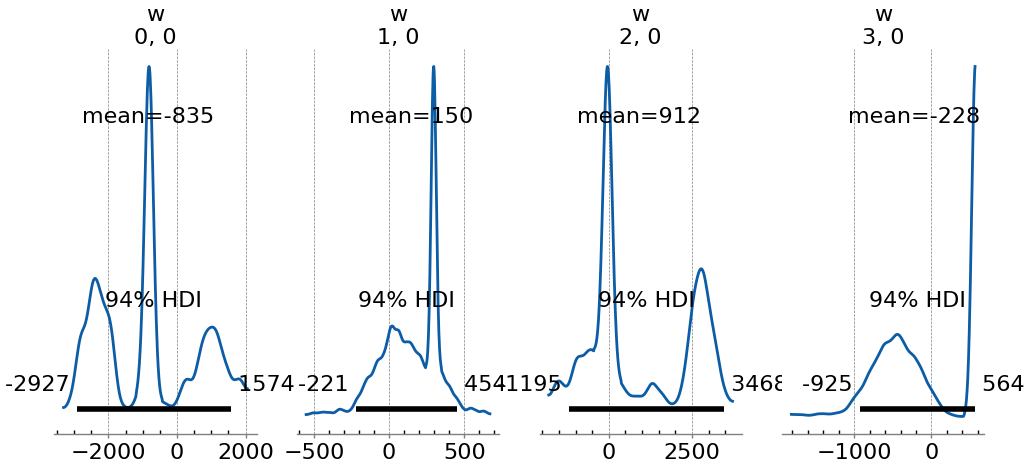

In [16]:
az.plot_posterior(lin_model_trace, var_names=["w"], figsize = (12,5))
plt.show()

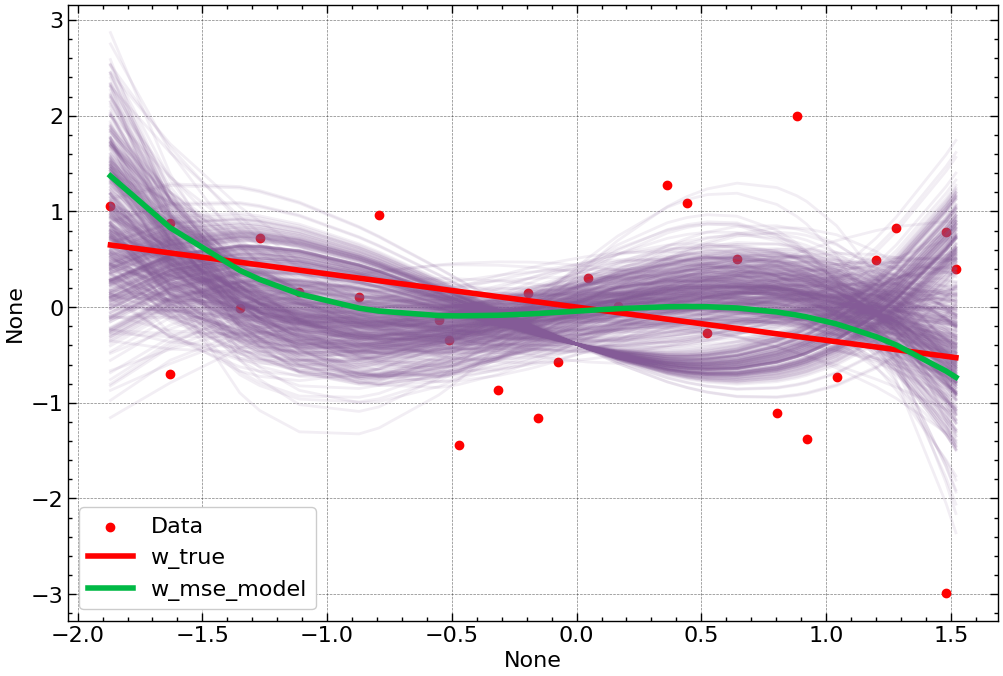

In [21]:
import xarray as xr
plt.figure(figsize=(12, 8))

post = az.extract(lin_model_trace, num_samples=500)

x_plot = xr.DataArray(X_normalize, dims=['x_dim_0', 'w_dim_0'])
lines = x_plot @ post["w"]

for i in range(lines.shape[2]):
    sns.lineplot(x=x_plot[:, 0], y=lines[:, 0, i], color="C4", alpha=0.1)

plt.scatter(X_normalize[:, 0], y_normalize, label="Data", color="r")

sns.lineplot(x=X_normalize[:, 0], y=(X_normalize[:,0] * w_normalize[0]), color='red', linewidth=4, label='w_true')
sns.lineplot(x=X_normalize[:, 0], y=(X_normalize @ w_mse_model_normalize)[:, 0], color='C1', linewidth=4, label='w_mse_model')

plt.legend()
plt.show()

Можно видеть как что при сильно скоррелированных признаках, небольшие ошибки в данных приводят к огромным последствиям в предсказании модели

С автоматическим подбором параметров регурелизации:

In [18]:
with pm.Model() as lin_model_reg:
    sigma_y = pm.HalfCauchy("sigma_y", beta=5)
    sigma_w = pm.HalfCauchy("sigma_w", beta=5)
    w_reg_model_pm = pm.Normal("w", 0, sigma = sigma_w, shape = (4,1))
    y_obs = pm.Normal("y_obs", X_normalize@w_reg_model_pm, sigma_y, observed=y_normalize)

lin_model_reg

In [19]:
with lin_model_reg:
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_y, sigma_w, w]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 448 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 647 divergences after tuning. Increase `target_accept` or reparameterize.


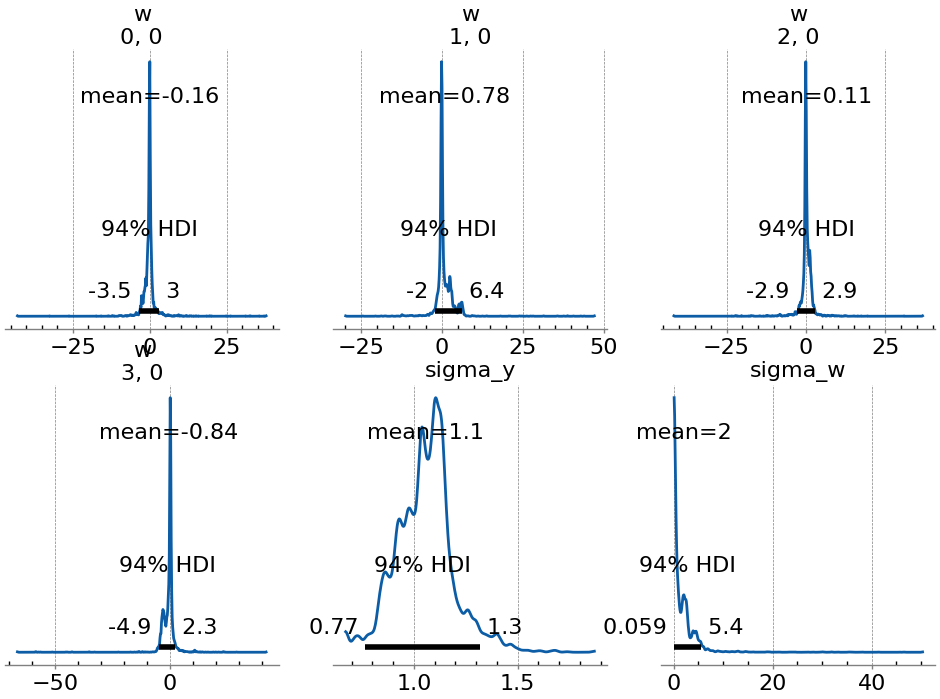

In [22]:
az.plot_posterior(idata, var_names=["w", "sigma_y", "sigma_w"], figsize = (12,8))
plt.show()

Можно заметить что лучшая оценка $\lambda = \frac{\sigma_y^2}{\sigma_w^2} \approx \frac{1}{4}$

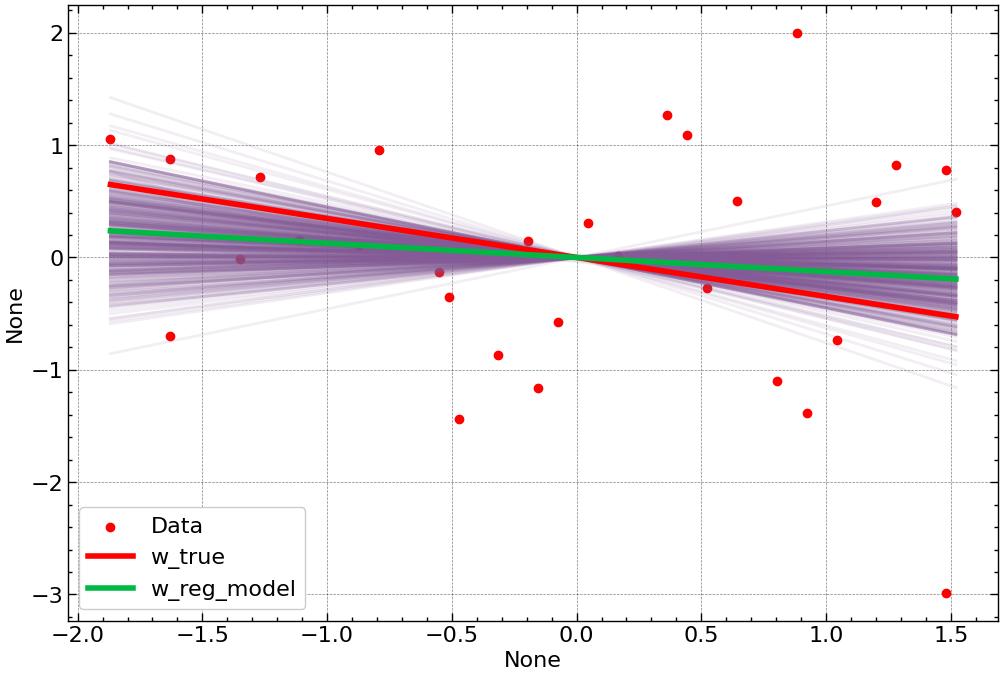

In [23]:
plt.figure(figsize=(12, 8))

post = az.extract(idata, num_samples=500)

lines = x_plot @ post["w"]

for i in range(lines.shape[2]):
    sns.lineplot(x=x_plot[:, 0], y=lines[:, 0, i], color="C4", alpha=0.1)

plt.scatter(X_normalize[:, 0], y_normalize, label="Data", color="r")

sns.lineplot(x=X_normalize[:, 0], y=(X_normalize[:,0] * w_normalize[0]), color='red', linewidth=4, label='w_true')
sns.lineplot(x=X_normalize[:, 0], y=(X_normalize @ w_reg_model)[:, 0], color='C1', linewidth=4, label='w_reg_model')

plt.legend()
plt.show()

В случае когда мы предполагаем, что наши данные пришли к нам из распределения лапласа $  y_i \sim Laplace(x_i^T w, b_y)  $, тогда в качестве сопряженного априорного распределения на веса мы также берем распрямление Лапласа, тогда:

$  \ln P(w|D) = \ln P(D|w) + \ln P(w) - \ln P(D) = -\sum\limits_i \frac{|x_i^T w - y_i|}{b_y} - \sum_j \frac{|w_j|}{b_w} + Const$

При нахождении максимума нашей вероятности $  P(w|D) $, получаем $\lambda = \frac{b_y}{b_w}$

Регуляризация при нормальном распределении называется $L_2$ или $Ridge$, так как там оптимизируется $L_2$ норма, а в случае распределения Лапласа $L_1$ или $Lasso$

In [39]:
with pm.Model() as l1_model:
    b_y = pm.HalfCauchy("b_y", beta=10)
    b_w = pm.HalfCauchy("b_w", beta=10)
    w_reg_model_pm = pm.Laplace("w", mu = 0, b = b_w, shape = (4,1))
    y_obs = pm.Laplace("y_obs", mu =X_normalize@w_reg_model_pm, b = b_y, observed=y_normalize)

l1_model

In [40]:
with l1_model:
    l1_idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b_y, b_w, w]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1906 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


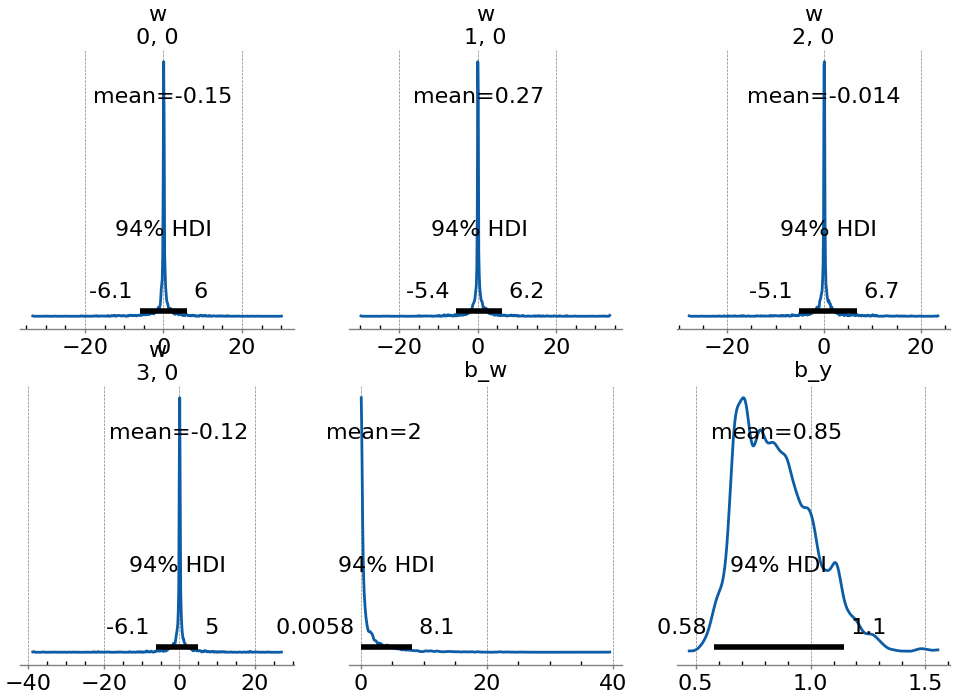

In [43]:
az.plot_posterior(l1_idata, var_names=["w", "b_w", "b_y"], figsize = (12,8))
plt.show()

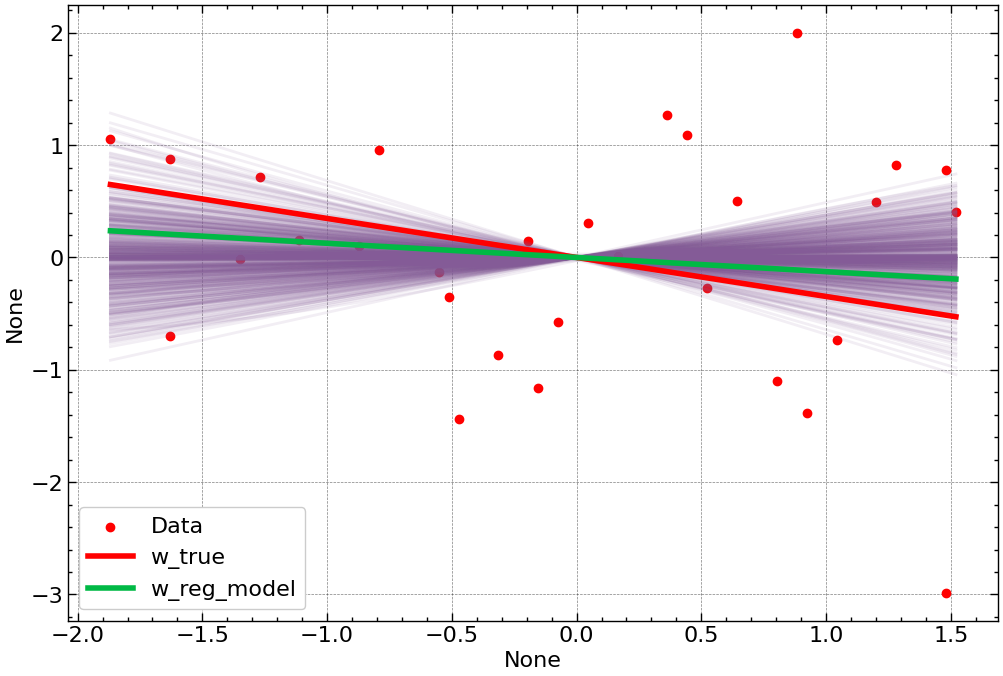

In [44]:
plt.figure(figsize=(12, 8))

post = az.extract(l1_idata, num_samples=500)

lines = x_plot @ post["w"]

for i in range(lines.shape[2]):
    sns.lineplot(x=x_plot[:, 0], y=lines[:, 0, i], color="C4", alpha=0.1)

plt.scatter(X_normalize[:, 0], y_normalize, label="Data", color="r")

sns.lineplot(x=X_normalize[:, 0], y=(X_normalize[:,0] * w_normalize[0]), color='red', linewidth=4, label='w_true')
sns.lineplot(x=X_normalize[:, 0], y=(X_normalize @ w_reg_model)[:, 0], color='C1', linewidth=4, label='w_mse_reg_model')

plt.legend()
plt.show()

## Регуляризация с точки зрения задачи оптимизации

Нахождение минимального значения функции потерь в модели с регуляризацией можно сравнить с процессом решения задачи оптимизации с помощью метода множителей Лагранжа. В случае $L2$-регуляризации, процесс максимизации апостериорной вероятности $P(w|D)$, эквивалентен максимизации правдоподобия $P(D|w)$ с ограничением, что сумма квадратов весов равна квадрату некоторой константы $R^2$. Это ограничение можно представить как условие, что вектор весов w лежит на поверхности n-мерного шара радиуса R. Таким образом, оптимальные значения весов w находятся в точке касания линий уровня функции вероятности $P(D|w)$ с линиями уровня n-мерного шара $w^Tw=R^2$.

При других видах регуляризации будут другие поверхности, которые можно посмотреть на рисунке ниже

![Reg](assets/reg.png)

Определитель истинной прямой:  30.000000000000004
Определитель модели:  1.1435027751360847e-05


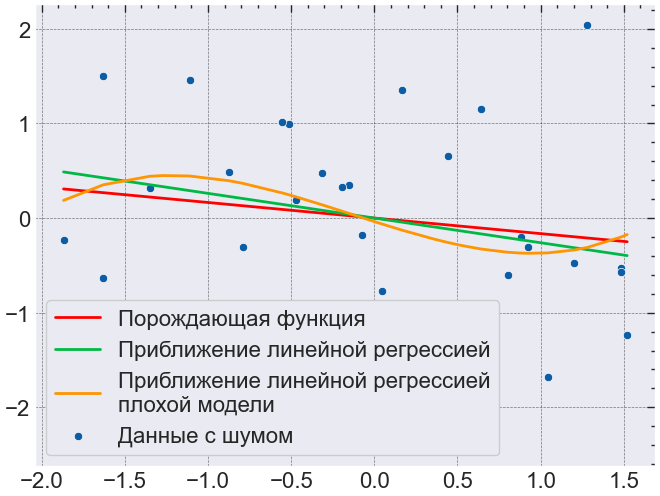

In [6]:
np.random.seed(23)

LinSp = np.linspace(-4,4,100)

n = 30
X = np.random.choice(LinSp, size = (n,1))
X_model = np.hstack([X, 3*X+0.0001*X**3])

means_X = np.mean(X_model, axis=0)[:, None]
stds_X = np.std(X_model, axis=0)[:, None]
X_model = (X_model - means_X.T) / stds_X.T

X = X_model[:,:1]

w_true = np.random.randn(1,1)
epsilon = np.random.randn(n,1)

y = X*w_true + epsilon

mean_y = np.mean(y)
std_y = np.std(y)
y = (y - mean_y) / std_y
w_true /= std_y

print("Определитель истинной прямой: ", np.linalg.det(X.T@X) )
print("Определитель модели: ", np.linalg.det(X_model.T@X_model))

w_mse_true = np.linalg.inv(X.T@X)@X.T@y
w_mse_model = np.linalg.inv(X_model.T@X_model)@X_model.T@y

sns.lineplot(x=X[:, 0], y=(X @ w_true)[:, 0], color='red', linewidth=2, label='Порождающая функция')
sns.lineplot(x=X[:, 0], y=(X @ w_mse_true)[:, 0], color='C1', linewidth=2, label='Приближение линейной регрессией')
sns.lineplot(x=X[:, 0], y=(X_model @ w_mse_model)[:, 0], color='C2', linewidth=2, label='Приближение линейной регрессией\nплохой модели')

sns.scatterplot(x=X[:, 0], y=y[:, 0], label='Данные с шумом')

plt.show()

In [7]:
w_true, w_mse_true, w_mse_model

(array([[-0.1646217]]),
 array([[-0.26100924]]),
 array([[-1174.80683018],
        [ 1174.5458284 ]]))

In [10]:
import tensorflow as tf

X_tensor = tf.constant(X_model, dtype=tf.float32)
y_tensor = tf.constant(y, dtype=tf.float32)

model = tf.keras.Sequential([ tf.keras.layers.Dense(units=1, input_shape=(2,), use_bias=False, activity_regularizer=tf.keras.regularizers.L2(1)) ])

model.compile(optimizer=tf.optimizers.RMSprop(), loss='mean_squared_error')

model.set_weights(np.array([[[-0.5],[0.5]]]))

In [9]:
model.fit(X_tensor, y_tensor, epochs=1000, verbose = False)
model.get_weights()

[array([[-0.5039384 ],
        [ 0.49651894]], dtype=float32)]

L1 регуляризация часто обнуляет коэффициенты

In [12]:
from sklearn.linear_model import Lasso, Ridge, ElasticNet

lasso = Lasso(alpha=0.1, fit_intercept=False) 
lasso.fit(X_model, y)

ridge = Ridge(alpha=0.1, fit_intercept=False)
ridge.fit(X_model, y)

elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5, fit_intercept=False)
elastic_net.fit(X_model, y)

print("L1 - Lasso:", lasso.coef_)
print("L2 - Ridge:", ridge.coef_)
print("L1+L2 ElasticNet:", elastic_net.coef_)

Lasso coefficients: [-0.16100924 -0.        ]
Ridge coefficients: [[-0.13252249 -0.12804501]]
ElasticNet coefficients: [-0.10317285 -0.10268711]


Посмотрим на линии уровня при различных регуляризациях

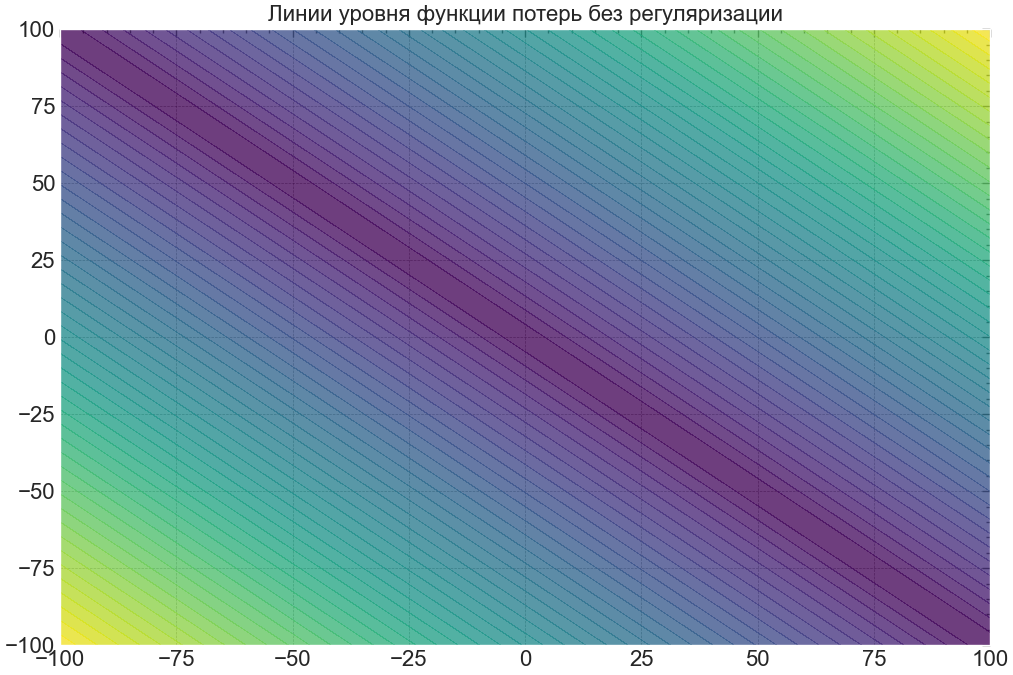

In [17]:
W0, W1 = np.meshgrid(np.linspace(-100, 100, 100), np.linspace(-100, 100, 100))
Z_no_reg = np.array([np.linalg.norm(X_model @ np.array([[w0], [w1]]) - y) for w0, w1 in zip(np.ravel(W0), np.ravel(W1))])
Z_no_reg = Z_no_reg.reshape(W0.shape)

plt.figure(figsize=(12,8))
plt.contourf(W0, W1, Z_no_reg, levels=50, cmap='viridis', alpha = 0.75)

plt.title('Линии уровня функции потерь без регуляризации')

plt.show()

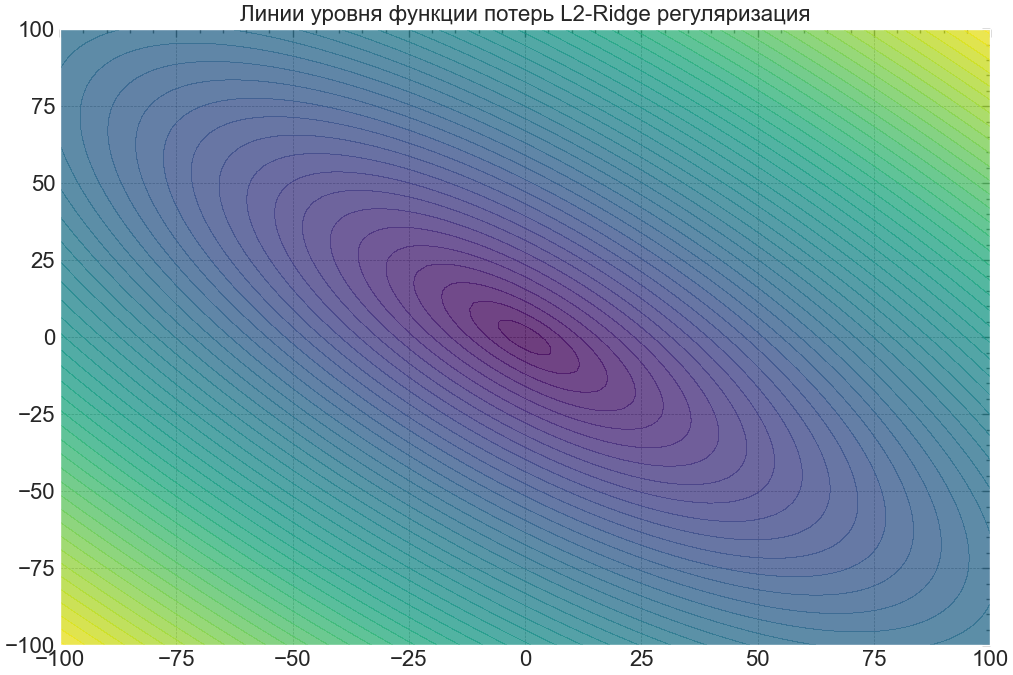

In [18]:
Z_ridge = np.array([np.sqrt(np.linalg.norm(X_model @ np.array([[w0], [w1]]) - y)**2+ 10* np.linalg.norm([[w0], [w1]])**2) for w0, w1 in zip(np.ravel(W0), np.ravel(W1))])
Z_ridge = Z_ridge.reshape(W0.shape)

plt.figure(figsize=(12,8))
plt.contourf(W0, W1, Z_ridge, levels=50, cmap='viridis', alpha = 0.75)

plt.title('Линии уровня функции потерь L2-Ridge регуляризация')

plt.show()

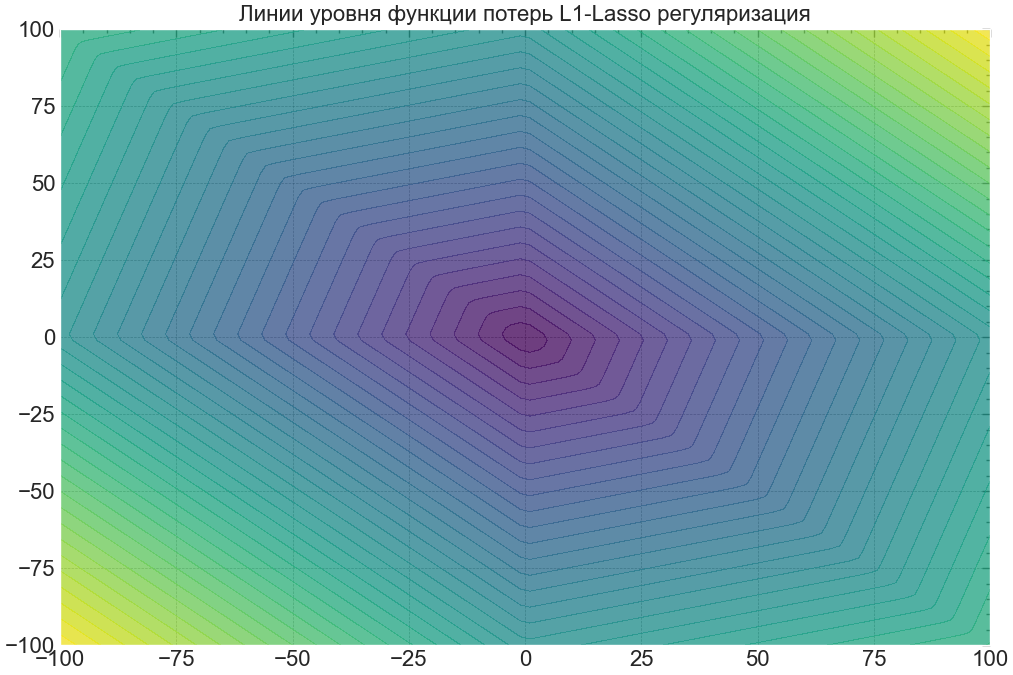

In [19]:
Z_lasso = np.array([np.linalg.norm(X_model @ np.array([[w0], [w1]]) - y, 2) + 10* np.linalg.norm([[w0], [w1]], 1) for w0, w1 in zip(np.ravel(W0), np.ravel(W1))])
Z_lasso = Z_lasso.reshape(W0.shape)

plt.figure(figsize=(12,8))
plt.contourf(W0, W1, Z_lasso, levels=50, cmap='viridis', alpha = 0.75)

plt.title('Линии уровня функции потерь L1-Lasso регуляризация')

plt.show()

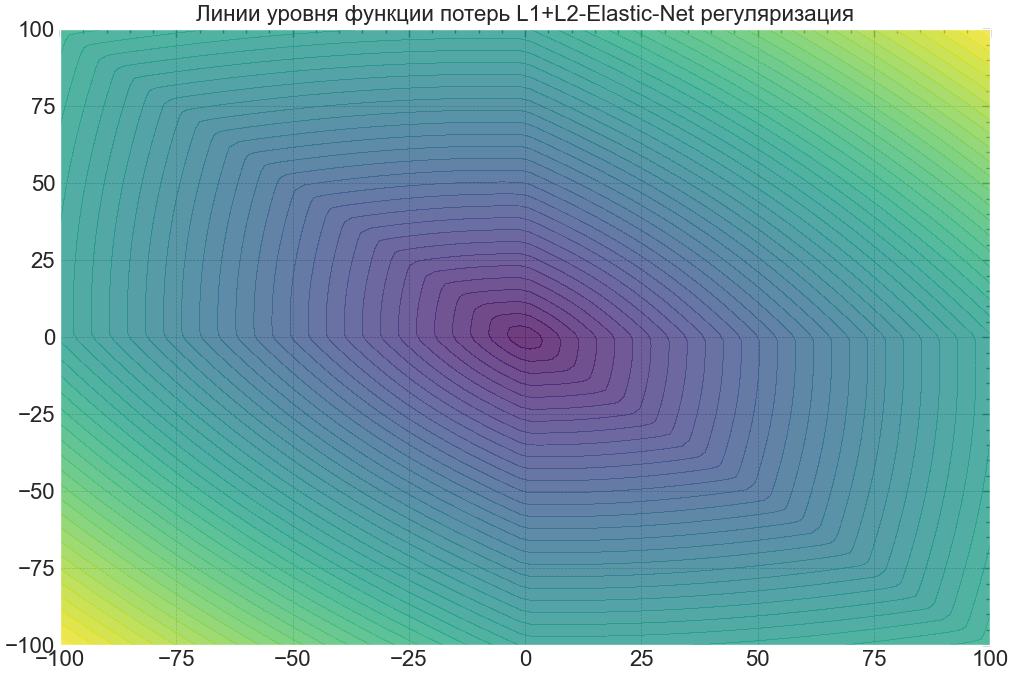

In [20]:
Z_elastic_net = np.array([np.linalg.norm(X_model @ np.array([[w0], [w1]]) - y, 2) + 10*(0.5*np.linalg.norm([[w0], [w1]], 1) + 0.5*np.linalg.norm([[w0], [w1]], 2)) for w0, w1 in zip(np.ravel(W0), np.ravel(W1))])
Z_elastic_net = Z_elastic_net.reshape(W0.shape)

plt.figure(figsize=(12,8))
plt.contourf(W0, W1, Z_elastic_net, levels=50, cmap='viridis', alpha = 0.75)

plt.title('Линии уровня функции потерь L1+L2-Elastic-Net регуляризация')

plt.show()